## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sn

from keras.datasets import mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from matplotlib import pyplot as plt
from plotnine import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

## Background of Data

Images are not in dcm format, the images are in jpg or png to fit the model

Data contain 3 lung cancer types which are Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma, and 1 folder for the normal cell

Data folder is the main folder that contain all the step folders
inside Data folder are test , train , valid

- test represent testing set
- train represent training set
- valid represent validation set
- training set is 70%
- testing set is 20%
- validation set is 10%

Adenocarcinoma
- Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer accounting for 30 percent of all cases overall and about 40 percent
of all non-small cell lung cancer occurrences
- Adenocarcinomas are found in several common cancers, including breast, prostate and colorectal
- Adenocarcinomas of the lung are found in the outer region of the lung
in glands that secrete mucus and help us breathe
- Symptoms include coughing, hoarseness, weight loss, and weakness.

Large cell carcinoma
- Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can be found anywhere in the lung
- This type of lung cancer usually accounts for 10 to 15 percent of all cases of NSCLC
- Large-cell undifferentiated carcinoma tends to grow and spread quickly

Squamous cell carcinoma
- Squamous cell: This type of lung cancer is found centrally in the lung, where the larger bronchi join the trachea to the lung,or in one of the main airway branches
- Squamous cell lung cancer is responsible for about 30 percent of all non-small
cell lung cancers, and is generally linked to smoking.

And the last folder is the normal CT-Scan images


## Reading in and Setting Up Data

In [ ]:
# make kaggle directory
!mkdir ~/.kaggle

# move kaggle.json to hidden kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions on file
!chmod 600 ~/.kaggle/kaggle.json

# download zipped data
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 99% 118M/119M [00:00<00:00, 202MB/s] 
100% 119M/119M [00:00<00:00, 172MB/s]


In [ ]:
!unzip -qq chest-ctscan-images.zip

In [ ]:
train_dir = "./Data/train"
test_dir = "./Data/test"
val_dir = "./Data/valid"

In [ ]:
batch_size = 32
image_width = 150
image_height = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir, # file path
  seed = 393, # seed
  image_size = (image_width, image_height), # size of image
  batch_size = batch_size, # number of images per batch
  labels ='inferred',  # Use inferred labels from subdirectories
  label_mode ='categorical') # One-hot encode the labels

Found 613 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir, # file path
  seed = 393, # seed
  image_size = (image_width, image_height), # size of image
  batch_size = batch_size, # number of images per batch
  labels ='inferred',  # Use inferred labels from subdirectories
  label_mode ='categorical') # One-hot encode the labels

Found 72 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir, # file path
  seed = 393, # seed
  image_size = (image_width, image_height), # size of image
  batch_size = batch_size, # number of images per batch
  labels ='inferred',  # Use inferred labels from subdirectories
  label_mode ='categorical') # One-hot encode the labels

Found 315 files belonging to 4 classes.


## Creating Model

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

model = kb.Sequential()

model.add(kb.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_width, image_height, 3)))
model.add(kb.layers.BatchNormalization())
model.add(kb.layers.MaxPooling2D((2, 2)))

model.add(kb.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.BatchNormalization())
model.add(kb.layers.MaxPooling2D((2, 2)))

model.add(kb.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.BatchNormalization())
model.add(kb.layers.MaxPooling2D((2, 2)))

model.add(kb.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.BatchNormalization())
model.add(kb.layers.MaxPooling2D((2, 2)))

model.add(kb.layers.Conv2D(512, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.BatchNormalization())
model.add(kb.layers.MaxPooling2D((2, 2)))

model.add(kb.layers.Flatten())

model.add(kb.layers.Dense(256, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.BatchNormalization())

model.add(kb.layers.Dense(128, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.Dropout(0.5))

model.add(kb.layers.Dense(64, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model.add(kb.layers.Dropout(0.3))

model.add(kb.layers.Dense(32, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))

model.add(kb.layers.Dense(4, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = kb.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [ ]:
# fit the model
history = model.fit(
    train_ds,                         # training data
    epochs = 100,
    validation_data = (val_ds),       # validation data
    callbacks = [early_stopping]
)

Epoch 1/100
20/20 [==============================] - 54s 2s/step - loss: 15.3118 - accuracy: 0.3605 - val_loss: 15.3069 - val_accuracy: 0.1806
Epoch 2/100
20/20 [==============================] - 49s 2s/step - loss: 14.9519 - accuracy: 0.4812 - val_loss: 15.1287 - val_accuracy: 0.1806
Epoch 3/100
20/20 [==============================] - 50s 2s/step - loss: 14.7977 - accuracy: 0.5661 - val_loss: 15.0027 - val_accuracy: 0.1806
Epoch 4/100
20/20 [==============================] - 48s 2s/step - loss: 14.5792 - accuracy: 0.6166 - val_loss: 14.8803 - val_accuracy: 0.1944
Epoch 5/100
20/20 [==============================] - 50s 2s/step - loss: 14.3850 - accuracy: 0.6558 - val_loss: 14.7536 - val_accuracy: 0.1944
Epoch 6/100
20/20 [==============================] - 50s 2s/step - loss: 14.2534 - accuracy: 0.6786 - val_loss: 14.5974 - val_accuracy: 0.3194
Epoch 7/100
20/20 [==============================] - 48s 2s/step - loss: 14.1180 - accuracy: 0.6933 - val_loss: 14.4461 - val_accuracy: 0.4722

<function matplotlib.pyplot.show(close=None, block=None)>

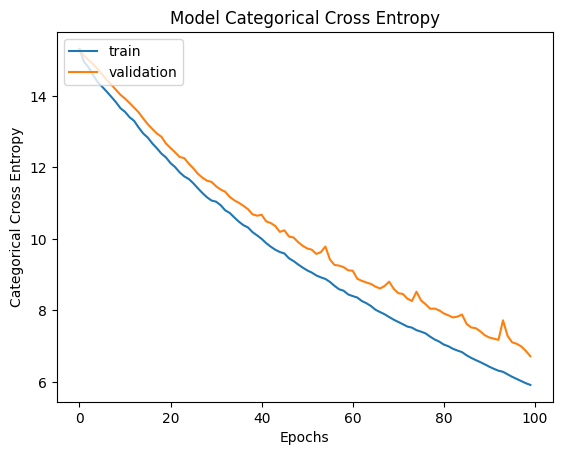

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Categorical Cross Entropy")
plt.ylabel("Categorical Cross Entropy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

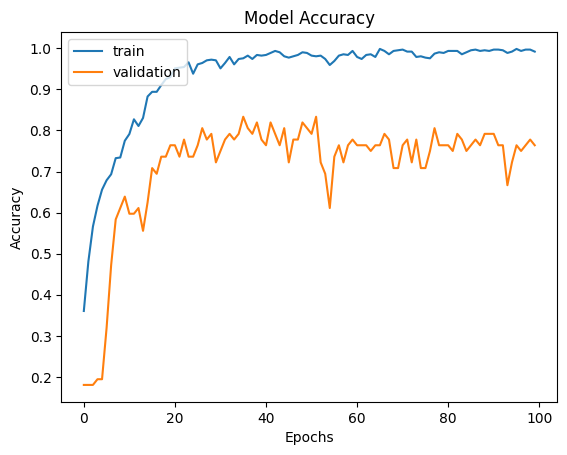

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

## Trying a Simpler Model

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

model2 = kb.Sequential()

model2.add(kb.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_width, image_height, 3)))
model2.add(kb.layers.BatchNormalization())
model2.add(kb.layers.MaxPooling2D((2, 2)))

model2.add(kb.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.BatchNormalization())
model2.add(kb.layers.MaxPooling2D((2, 2)))

model2.add(kb.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.BatchNormalization())
model2.add(kb.layers.MaxPooling2D((2, 2)))

model2.add(kb.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.BatchNormalization())
model2.add(kb.layers.MaxPooling2D((2, 2)))

model2.add(kb.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.BatchNormalization())
model2.add(kb.layers.MaxPooling2D((2, 2)))

model2.add(kb.layers.Flatten())

model2.add(kb.layers.Dense(256, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.BatchNormalization())

model2.add(kb.layers.Dense(128, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.Dropout(0.5))

model2.add(kb.layers.Dense(64, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))
model2.add(kb.layers.Dropout(0.3))

model2.add(kb.layers.Dense(32, activation = 'relu', kernel_regularizer = kb.regularizers.l2()))

model2.add(kb.layers.Dense(4, activation = 'softmax'))

model2.compile(loss = 'categorical_crossentropy', optimizer = kb.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [ ]:
# fit the model
history = model2.fit(
    train_ds,                         # training data
    epochs = 100,
    validation_data = (val_ds),       # validation data
    callbacks = [early_stopping]
)

Epoch 1/100
20/20 [==============================] - 54s 3s/step - loss: 10.3013 - accuracy: 0.8972 - val_loss: 10.7119 - val_accuracy: 0.6944
Epoch 2/100
20/20 [==============================] - 43s 2s/step - loss: 10.2426 - accuracy: 0.8972 - val_loss: 10.6129 - val_accuracy: 0.7222
Epoch 3/100
20/20 [==============================] - 42s 2s/step - loss: 10.1175 - accuracy: 0.9233 - val_loss: 10.5492 - val_accuracy: 0.7083
Epoch 4/100
20/20 [==============================] - 45s 2s/step - loss: 10.0374 - accuracy: 0.9168 - val_loss: 10.4844 - val_accuracy: 0.7083
Epoch 5/100
20/20 [==============================] - 43s 2s/step - loss: 9.9904 - accuracy: 0.9135 - val_loss: 10.3738 - val_accuracy: 0.7778
Epoch 6/100
20/20 [==============================] - 44s 2s/step - loss: 9.8749 - accuracy: 0.9299 - val_loss: 10.3747 - val_accuracy: 0.6944
Epoch 7/100
20/20 [==============================] - 44s 2s/step - loss: 9.8348 - accuracy: 0.9119 - val_loss: 10.2509 - val_accuracy: 0.7222
Ep

<function matplotlib.pyplot.show(close=None, block=None)>

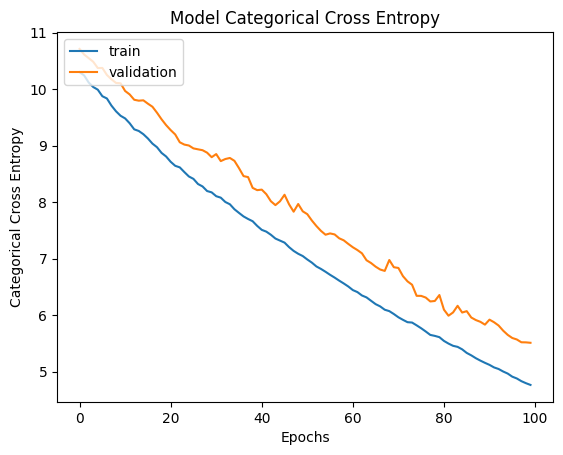

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Categorical Cross Entropy")
plt.ylabel("Categorical Cross Entropy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

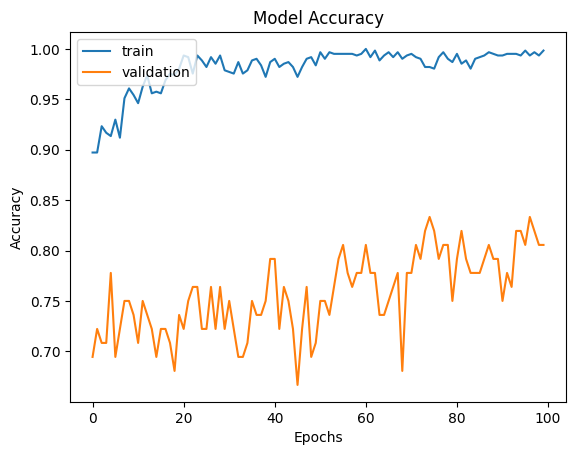

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show